<a href="https://colab.research.google.com/github/c-daly/Notebooks/blob/main/ML_HW1_DecisionTreesAndRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS 6140 Machine Learning: Assignment - 1 (Total Points: 100)
## Prof. Ahmad Uzair 

Just some high level imports.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

### Q1. Decision Tree Classifier (50 points)

### Q1.1 Growing Decison Trees from scratch (40 points)

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal of this question in the assignment is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. 
You must also print the Decision Tree. Use information gain based on entropy as the splitting measure. 

Use the data.csv dataset for this particular question. The dataset should be uploaded on Canvas with Assignment 1. Split the dataset into training and test data and calculate testing accuracy.



Just setting some helpful constants and splitting the data.

In [ ]:
FALSE = 0
TRUE = 1

CLASS_0 = 0
CLASS_1 = 1
CLASS_2 = 2
LABEL_VALUES = [CLASS_0, CLASS_1, CLASS_2]
LABEL_COLUMN = 'class'

PLURALITY = 'Plurality'
UNANIMOUS = 'Unanimous'
DECISION_TYPES = [PLURALITY, UNANIMOUS]

# read and split the data
df = pd.read_csv('data.csv')
train_df, test_df = train_test_split(df, test_size=0.2)

Data structures to implement the decision tree.

In [ ]:
# Main element of the decision tree
class Node:
  def __init__(self, attribute, value):
    self.attribute = attribute
    self.value = value
    self.children = []

class DecisionTree:
  def __init__(self, node):
    self.node = node
    self.root = node
  
  # uses existing tree to classify new example
  def classify(self, example):
    iteration = 0
    node = self.node

    while True:
      if node.value in DECISION_TYPES:
        return node.attribute
      elif example[node.attribute] < node.value:
        node = node.children[TRUE]
      elif len(node.children) > 1:
        node = node.children[FALSE]
      else:
        print(f"{node.attribute}")
        return node.attribute

These are the functions that do most of the work.

In [ ]:
# Entropy calculation based on frequency of class labels.
#
# examples: dataset on which to calculate entropy
def calculateEntropy(examples):
  label = examples[LABEL_COLUMN]
  _, counts = np.unique(label, return_counts=True)
  probabilities = counts/counts.sum()
  entropy = sum(probabilities * -np.log2(probabilities))
  return entropy

# Entropy calculation for the children
#
# lt_examples: dataset of values less than the threshold
# gte_examples: dataset of values greater than or equal 
#               to the threshold
# returns: a float representing the average entropy of the children
def calculateRemainder(lt_examples, gte_examples):
  total_len = len(lt_examples) + len(gte_examples)
  lt_entropy = calculateEntropy(lt_examples)
  gte_entropy = calculateEntropy(gte_examples)

  remainder = len(lt_examples)/total_len * lt_entropy + len(gte_examples)/total_len * gte_entropy
  return remainder

# Remove a feature/column from a dataset
#
# examples: dataset to drop column from
# feature: feature/column to drop
def dropFeatureColumn(examples, feature):
  return examples.drop([feature], axis=1)

# Split a given dataset on feature < val
# into two separate datasets, lt and gte
#
# examples: dataset to split
# feature: feature to split on
# val: threshold to use for splitting
#
# returns: two datasets, one less than and one greater than
#          the threshold
def splitData(examples, feature, val):
  # nothing to split on, return nothing
  if feature is None or val is None:
    return None, None

  lt = examples[(examples[feature] < val)]
  gte = examples[(examples[feature] >= val)]

  lt = dropFeatureColumn(lt, feature)
  gte = dropFeatureColumn(gte, feature)

  return lt, gte

# get all the values in a column
#
# examples: dataset from which to fetch examples
# feature: column/feature to fetch values from
def getValuesByFeature(examples, feature):
  return examples[feature]

# get all examples belonging to class == class_label
#
# examples: dataset from which to fetch examples
# class_label: class we want examples for
def getExamplesByClass(examples, class_label):
   value_examples = examples[(examples[LABEL_COLUMN] == class_label)]
   return value_examples

# This method stitches together the entropy calculations
# to measure information gain (IG)
#
# examples: current dataset
# feature: current feature/column
# value: threshold value for splitting
def calculateGainForFeatureAndValue(examples, feature, value):
  lt_count = 0
  gte_count = 0
  lt, gte = splitData(examples, feature, value)
  gain = calculateEntropy(examples) - calculateRemainder(lt, gte)
  return gain

# Determine the best possible spllit for a given dataset
# based on information gain.
#
# examples: current dataset
def getBestSplit(examples):
  features = examples.columns
  gain = 0
  split_feature = None
  split_value = None
  temp_gain = 0
  # all features but the class label
  for feature in features[:-1]:
    values = getValuesByFeature(examples, feature).unique()
    # iterate over all possible features for this value
    for value in values:
      temp_gain = calculateGainForFeatureAndValue(examples, feature, value)
      # we've found a better split
      if temp_gain > gain:
        gain = temp_gain
        split_feature = feature
        split_value = value
  # return the best split
  return split_feature, split_value
        
# get most frequent class for a set of examples
#
# examples: current dataset
#
# returns: the most common value in a column
def getPluralityValue(examples):
  return examples[LABEL_COLUMN].mode()[0]

# recursive method that learns a decision tree
# for a given dataset using information gain as a metric.
#
# examples: current dataset
# parent_examples: dataset from parent
# 
# returns: An appropriately fromed Node, given the provided data.
def learnTree(examples, parent_examples):
  # Check all the reasons we might be done
  if examples is None or len(examples) == 0:
    return Node(getPluralityValue(parent_examples), PLURALITY)
  elif len(examples[LABEL_COLUMN].unique()) == 1:
    return Node(examples[LABEL_COLUMN].values[0], UNANIMOUS)
  elif len(examples.columns) < 2:
    return Node(getPluralityValue(examples), PLURALITY)
  # We're not done
  else:
    # We're going find the best split 
    # and create a node for our current feature/value.
    # Recursively invoke learnTree to create child nodes.
    feature, val = getBestSplit(examples)
    node = Node(feature, val)
    lt, gte = splitData(examples, feature, val)
    node.children = [None, None]
    node.children[TRUE] = learnTree(lt, examples)
    node.children[FALSE] = learnTree(gte, examples)
    return node

Printing stuff

In [ ]:
# Basic utility class for printing the decision tree
class TreePrinter():
  def __init__(self, root):
    self.root = root
  
  # Prints the entire tree.
  def printTree(self):
    self.printNode(self.root, 1)
  
  # print the node of a tree. Recursively invokes
  # printNode for children.
  #
  # node: the current node we're printing
  # tree_level: how far down the tree are we?
  def printNode(self, node, tree_level):
    if node.children is not None:
      indent_string = '|\t' * (tree_level - 1)
      if len(node.children) == 0:
        print(f"{indent_string}{tree_level}: Leaf with value {node.attribute}, {node.value} decision.")
      else:
        print(f"{indent_string}{tree_level}: {node.attribute} at {node.value}")
      if len(node.children) > 0: # and node.children[TRUE] is not None:
        self.printNode(node.children[TRUE], tree_level + 1)
      if len(node.children) > 1: # and node.children[FALSE] is not None:
        self.printNode(node.children[FALSE], tree_level + 1)



Evaluation stuff

In [ ]:
node = learnTree(train_df, None)
dt = DecisionTree(node)

tp = TreePrinter(node)
tp.printTree()

y_pred = []
y_actual = test_df[LABEL_COLUMN].values
#for i in range(0,len(test_df)):
#  y_pred.append(dt.classify(test_df.iloc[i]))
  #print(f"estimate: {dt.classify(test_df.iloc[i])}, actual: {test_df.iloc[i][LABEL_COLUMN]}") 
y_pred = test_df.apply(dt.classify, axis = 1)
cm_scratch = confusion_matrix(y_pred, y_actual)

1: feature3 at 3.0
|	2: Leaf with value 0, Unanimous decision.
|	2: feature4 at 1.8
|	|	3: feature1 at 7.2
|	|	|	4: feature2 at 2.3
|	|	|	|	5: Leaf with value 1, Plurality decision.
|	|	|	|	5: Leaf with value 1, Plurality decision.
|	|	|	4: Leaf with value 2, Unanimous decision.
|	|	3: feature1 at 6.0
|	|	|	4: feature2 at 3.2
|	|	|	|	5: Leaf with value 2, Unanimous decision.
|	|	|	|	5: Leaf with value 1, Unanimous decision.
|	|	|	4: Leaf with value 2, Unanimous decision.


For the output above, the node shows what decision was made at a given point.  So, at the root, the algorithm chose to split on feature3 with value 3.3, and the children are the nodes representing the resulting datasets. That initial split was able to classify one branch as class 0, but the other went on to be split on feature 4 at 1.8.

Unanimous or Plurality decision indicate whether the classification was made because all elements had the same class (unanimous), or the most frequently occurring (plurality).

### Q1.2 Decision Tree using Sklearn Library (10 points)

Use the Decision Tree Classifier from the Sklearn Library and use gini index as a splitting measure. Use the data.csv dataset.
Calculate accuracy for this model. 
Print the Decision tree and compare the Decision Trees generated from your code and Sklearn.

|--- feature_3 <= 0.80
|   |--- class: 0
|--- feature_3 >  0.80
|   |--- feature_2 <= 4.75
|   |   |--- class: 1
|   |--- feature_2 >  4.75
|   |   |--- feature_3 <= 1.75
|   |   |   |--- feature_1 <= 2.45
|   |   |   |   |--- class: 2
|   |   |   |--- feature_1 >  2.45
|   |   |   |   |--- feature_2 <= 5.05
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_2 >  5.05
|   |   |   |   |   |--- feature_0 <= 6.15
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_0 >  6.15
|   |   |   |   |   |   |--- class: 2
|   |   |--- feature_3 >  1.75
|   |   |   |--- feature_2 <= 4.85
|   |   |   |   |--- feature_0 <= 5.95
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_0 >  5.95
|   |   |   |   |   |--- class: 2
|   |   |   |--- feature_2 >  4.85
|   |   |   |   |--- class: 2


Confusion Matrix:
[[ 8  0  0]
 [ 0 12  0]
 [ 0  2  8]]



[Text(0.3, 0.9285714285714286, 'X[3] <= 0.8\ngini = 0.666\nsamples = 120\nvalue = [42, 38, 40]'),
 Text(0.2, 0.7857142857142857, 'gini = 0.0\nsamples = 42\nvalue = [42, 0, 0]'),
 Text(0.4, 0.7857142857142857, 'X[2] <= 4.75\ngini = 0.5\nsamples = 78\nvalue = [0, 38, 40]'),
 Text(0.3, 0.6428571428571429, 'gini = 0.0\nsamples = 34\nvalue = [0, 34, 0]'),
 Text(0.5, 0.6428571428571429, 'X[3] <= 1.75\ngini = 0.165\nsamples = 44\nvalue = [0, 4, 40]'),
 Text(0.2, 0.5, 'X[1] <= 2.45\ngini = 0.5\nsamples = 6\nvalue = [0, 3, 3]'),
 Text(0.1, 0.35714285714285715, 'gini = 0.0\nsamples = 1\nvalue = [0, 0, 1]'),
 Text(0.3, 0.35714285714285715, 'X[2] <= 5.05\ngini = 0.48\nsamples = 5\nvalue = [0, 3, 2]'),
 Text(0.2, 0.21428571428571427, 'gini = 0.0\nsamples = 2\nvalue = [0, 2, 0]'),
 Text(0.4, 0.21428571428571427, 'X[0] <= 6.15\ngini = 0.444\nsamples = 3\nvalue = [0, 1, 2]'),
 Text(0.3, 0.07142857142857142, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0]'),
 Text(0.5, 0.07142857142857142, 'gini = 0.0\nsam

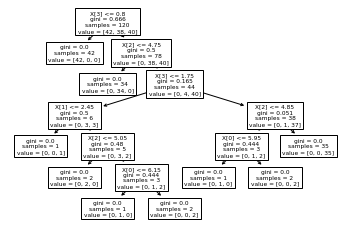

In [ ]:
# y is just the label
y = train_df['class']
test_y = test_df['class']

# drop the label from X
X = train_df.drop(['class'], axis=1)
test_X = test_df.drop(['class'], axis=1)

# defaults to gini
dt = tree.DecisionTreeClassifier()
dt = dt.fit(X,y)

# printing
y_pred = dt.predict(test_X)
cm_sklearn = confusion_matrix(test_y, y_pred)

print(f"{tree.export_text(dt)}\n")
print("Confusion Matrix:")
print(f"{cm_sklearn}\n")
tree.plot_tree(dt)

The cell below just shows the confusion matrices from the decision tree created from scratch that uses information gain, followed by the sk learn tree, which uses gini.

In [ ]:
print(f"From scratch w/entroy:\n{cm_scratch}\n")
print(f"Sk learn with gini:\n{cm_sklearn}")

From scratch w/entroy:
[[ 8  0  0]
 [ 0 12  2]
 [ 0  0  8]]

Sk learn with gini:
[[ 8  0  0]
 [ 0 12  0]
 [ 0  2  8]]


### Q2 Linear Regression (40 points)

Linear regression attempts to model the relationship between two variables by fitting a linear equation to observed data. One variable is considered to be an explanatory variable, and the other is considered to be a dependent variable. 
<br>


## Gradient descent algorithm 
\begin{equation}
\theta^{+} = \theta^{-} + \frac{\alpha}{m} (y_{i} - h(x_{i}) )\bar{x}
\end{equation}

This minimizes the following cost function

\begin{equation}
J(x, \theta, y) = \frac{1}{2m}\sum_{i=1}^{m}(h(x_i) - y_i)^2
\end{equation}

where
\begin{equation}
h(x_i) = \theta^T \bar{x}
\end{equation}

In [ ]:
# Do not change the code in this cell
true_slope = 15
true_intercept = 2.4
input_var = np.arange(0.0,100.0)
output_var = true_slope * input_var + true_intercept + 300.0 * np.random.rand(len(input_var))

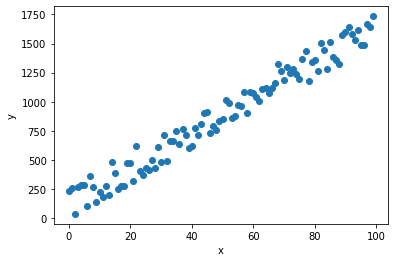

In [ ]:
# Do not change the code in this cell
plt.figure()
plt.scatter(input_var, output_var)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
def compute_cost(ip, op, params):
    """
    Cost function in linear regression where the cost is calculated
    ip: input variables
    op: output variables
    params: corresponding parameters
    Returns cost
    """
    num_samples = len(ip)
    cost_sum = 0.0
    for x,y in zip(ip, op):
        y_hat = np.dot(params, np.array([1.0, x]))
        cost_sum += (y_hat - y) ** 2
    
    cost = cost_sum / (num_samples)
    
    return cost

### Q2.1 Implement Linear Regression using Batch Gradient Descent from scratch.  (15 points)


### Batch gradient descent
Algorithm can be given as follows:

```for j in 0 -> max_iteration: 
    for i in 0 -> m: 
        theta += (alpha / m) * (y[i] - h(x[i])) * x_bar
```

 I really tried my hardest to complete this question using vector/matrix operations rather than operating on each component, but I found my learning rate needed to be adjusted in that scenario, which isn't permitted.  I still don't understand why that should be the case. 

  In order to complete the exercise without changing the learning rate, I switched to operating on an example at a time. I left the code in the cell, but commented out to show my thought process.


In [ ]:
def linear_regression_using_batch_gradient_descent(ip, op, params, alpha, max_iter):
    """
    Compute the params for linear regression using batch gradient descent
    ip: input variables
    op: output variables
    params: corresponding parameters
    alpha: learning rate
    max_iter: maximum number of iterations
    Returns parameters, cost, params_store
    """ 
    # initialize iteration, number of samples, cost and parameter array
    iteration = 0
    num_samples = len(ip)
    cost = np.zeros(max_iter)
    params_store = np.zeros([2, max_iter])
    
    # These variables were meant to support calculating
    # the gradient at the matrix level.
    #intercepts = np.ones_like(ip)
    #X = np.array([np.ones(len(ip)), ip.flatten()]).T 

    # Compute the cost and store the params for the corresponding cost
    while iteration < max_iter:
        cost[iteration] = compute_cost(ip, op, params)
        params_store[:, iteration] = params
        
        print('--------------------------')
        print(f'iteration: {iteration}')
        print(f'cost: {cost[iteration]}')
        print(f'params: {params}')
 
 
        # Apply batch gradient descent

        # ended up looping over each example
        for x, y in zip(ip, op):
          y_hat = np.dot(params, np.array([1.0, x]))
          gradient = np.array([1.0, x]) * (y - y_hat)
          params += alpha * gradient/num_samples
           
        # The below code was my attempt to use
        # matrix computations to avoid explicitly
        # looping.  It worked, but not without modifying
        # alpha, which was prohibited. Not sure why it 
        # would appear to work, but only with a reduced learning rate.

        #preds = X.dot(params)
        #loss = op - preds
        #grad = loss.dot(X)
        #new_params = (alpha/len(X)) * grad
        #params += new_params

        iteration += 1    
    return params, cost, params_store

In [ ]:
# Do not change the code in this cell
# Training the model
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(input_var, output_var, test_size=0.20)

params_0 = np.array([20.0, 80.0])

alpha_batch = 1e-3
max_iter = 100
params_hat_batch, cost_batch, params_store_batch =\
    linear_regression_using_batch_gradient_descent(x_train, y_train, params_0, alpha_batch, max_iter)

--------------------------
iteration: 0
cost: 11910175.085004052
params: [20. 80.]
--------------------------
iteration: 1
cost: 34693.87267492755
params: [19.11365509 19.77550869]
--------------------------
iteration: 2
cost: 9918.993731939318
params: [19.10016328 17.06205194]
--------------------------
iteration: 3
cost: 9836.864925339762
params: [19.12598503 16.93938474]
--------------------------
iteration: 4
cost: 9833.813196061466
params: [19.1535706 16.933429 ]
--------------------------
iteration: 5
cost: 9832.227091165758
params: [19.18122844 16.93273106]
--------------------------
iteration: 6
cost: 9830.703523962617
params: [19.20888233 16.9322701 ]
--------------------------
iteration: 7
cost: 9829.183557850012
params: [19.23652884 16.93181992]
--------------------------
iteration: 8
cost: 9827.664547088209
params: [19.26416783 16.93137035]
--------------------------
iteration: 9
cost: 9826.146372123892
params: [19.29179929 16.93092093]
--------------------------
iteration:

Assigning the cost_batch variable to bgd_costs for clarity.

In [ ]:
bgd_costs = cost_batch

### Q2.2 Implement Stochastic Gradient Descent from scratch. (15 points)

### Stochastic Gradient Descent
Algorithm can be given as follows:
```shuffle(x, y)
for i in 0 -> m:
    theta += (alpha / m) * (y[i] - h(x[i])) * x_bar  
```

Ordinarily, I would have expected to loop for some configured number of iterations, each time selecting a random example from the training data on which to perform gradient descent, but I was advised in office hours that since the train/test split is already a random sample, we can simply loop over our training data, so that's what I did here.


In [ ]:
def lin_reg_stoch_gradient_descent(ip, op, params, alpha):
    """
    Compute the params for linear regression using stochastic gradient descent
    ip: input variables
    op: output variables
    params: corresponding parameters
    alpha: learning rate
    Returns parameters, cost, params_store
    """
    # input_var and output_var are global vars
    # and are being used instead of the method args
    # which have been appropriately split.  Assigning
    # those values to input_var and output_var to correct.
    input_var = ip
    output_var = op 
    # initialize iteration, number of samples, cost and parameter array
    num_samples = len(input_var)
    cost = np.zeros(num_samples)
    params_store = np.zeros([2, num_samples])
    
    i = 0
    # Compute the cost and store the params for the corresponding cost
    for x,y in zip(input_var, output_var):
        cost[i] = compute_cost(input_var, output_var, params)
        params_store[:, i] = params
        
        print('--------------------------')
        print(f'iteration: {i}')
        print(f'cost: {cost[i]}')
        print(f'params: {params}')
        
        # Apply stochastic gradient descent
        y_hat = np.dot(params, np.array([1.0, x]))
        gradient = np.array([1.0, x]) * (y - y_hat)
        params += alpha * gradient/num_samples                    

        i += 1
    return params, cost, params_store

In [ ]:
# Do not change the code in this cell
alpha = 1e-3
params_0 = np.array([20.0, 80.0])
params_hat, cost, params_store =\
lin_reg_stoch_gradient_descent(x_train, y_train, params_0, alpha)

--------------------------
iteration: 0
cost: 11910175.085004052
params: [20. 80.]
--------------------------
iteration: 1
cost: 10826051.309154604
params: [19.95175116 77.05682078]
--------------------------
iteration: 2
cost: 9200477.316152483
params: [19.89219045 72.35152444]
--------------------------
iteration: 3
cost: 8317555.639244497
params: [19.84883835 69.62034246]
--------------------------
iteration: 4
cost: 8169485.516439803
params: [19.83136232 69.14848958]
--------------------------
iteration: 5
cost: 8133031.1952157
params: [19.82238141 69.03173774]
--------------------------
iteration: 6
cost: 8132084.029348101
params: [19.82087277 69.02872047]
--------------------------
iteration: 7
cost: 7991018.709885463
params: [19.80338924 68.57414854]
--------------------------
iteration: 8
cost: 7297499.881769617
params: [19.76511562 66.27773157]
--------------------------
iteration: 9
cost: 5634891.849953597
params: [19.70452869 60.2796257 ]
--------------------------
iteration

Assigning cost to a new variable sgd_cost for clarity.

In [ ]:
sgd_costs = cost

### Q2.3 Calculate Root Mean Square error in batch gradient descent algorithm and stochastic gradient descent algorithm (5 points)

In [ ]:
# Calculate Root Mean Square error in batch gradient descent algorithm and stochastic gradient descent algorithm
bgd_rmse = np.sqrt(bgd_costs.sum()/len(bgd_costs))
sgd_rmse = np.sqrt(sgd_costs.sum()/len(sgd_costs))

print(f"BGD RMSE: {bgd_rmse}")
print(f"SGD RMSE: {sgd_rmse}")


BGD RMSE: 359.1913660839094
SGD RMSE: 1457.0497466556374


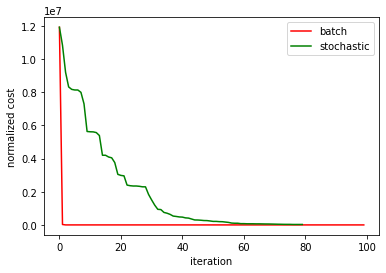

min cost with BGD: 9692.854034511136
min cost with SGD: 36532.75363840992


In [ ]:
# Do not change the code in this cell
plt.figure()
plt.plot(np.arange(max_iter), cost_batch, 'r', label='batch')
plt.plot(np.arange(len(cost)), cost, 'g', label='stochastic')
plt.xlabel('iteration')
plt.ylabel('normalized cost')
plt.legend()
plt.show()
print(f'min cost with BGD: {np.min(cost_batch)}')
print(f'min cost with SGD: {np.min(cost)}')

### Q2.4 Which linear regression model do you think works best for this data? Explain in brief. (5 points)

The data obtained in these exercises shows that BGD performs much better on this dataset, and that makes intuitive sense, given that we are calculating the gradient based on each example every iteration, instead of just the one random one in SGD.

That said, I was a bit surprised at just how much worse SGD performed in this instance. I believe the results would be much less skewed if the dataset were quite a bit larger and we had more iterations. In that instance, SGD would become more attractive for performance reasons as well, though my reading tells me we should prefer a minibatch version of SGD.

### Q3. Linear Regression Analytical Problem (10 points)
Consider the following training data.

| X1 | X2 | Y |
| -- | -- | -- |
| 0 | 0 | 0 |
| 0 | 1 | 1.5 |
| 1 | 0 | 2 |
| 1 | 1 | 2.5 |
Suppose the data comes from a model y = $θ_{0}$ +$θ_{1}$x1 +$θ_{2}$x2 for unknown constants $θ_{0}$,$θ_{1}$,$θ_{2}$. Use least squares linear regression to find an estimate of $θ_{0}$,$θ_{1}$,$θ_{2}$.

This is a straightforward problem for np.linalg.solve.  We just need to set up the appropriate design matrix (including 1s for bias) and y vector.

In [ ]:
X = np.array([[1, 0, 0],
              [1, 0, 1],
              [1, 1, 0],
              [1, 1, 1]])

y = np.array([0, 1.5, 2, 2.5])

XTX = np.dot(X.T,X)
XTy = np.dot(X.T, y)

weights = np.linalg.solve(XTX, XTy)
print(f"Theta0 = {weights[0]}, Theta1 = {weights[1]}, Theta2 = {weights[2]} ")

Theta0 = 0.25, Theta1 = 1.5, Theta2 = 1.0 
